In [3]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.utils import make_grid
from PIL import Image
%matplotlib inline

In [4]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            residual = self.downsample(residual)
            
        x += residual
        x = F.relu(x)
        
        return x
    
class ResNet(nn.Module):
    def __init__(self, block, layers, out_channels=10):
        super().__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1], 2)
        self.layer3 = self._make_layer(block, 64, layers[2], 2)
        self.layer4 = self._make_layer(block, 128, layers[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, out_channels)
        
    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding_net = ResNet(ResidualBlock, [2, 2, 2, 2], out_channels=10)
        
    def get_embedding(self, x):
        return self.embedding_net(x)
        
    def forward(self, a, p, n):
        a_out = self.embedding_net(a)
        p_out = self.embedding_net(p)
        n_out = self.embedding_net(n)
        return (a_out, p_out, n_out)
    
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork().to(device)
# Load checkpoint
checkpoint = torch.load('checkpoint_online', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

filenames_embeddings = torch.load('filenames_embeddings')
filenames = filenames_embeddings['filenames']
embeddings = filenames_embeddings['embeddings']

torch.Size([3, 217, 178])


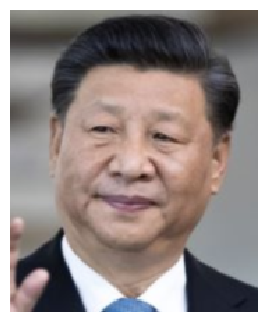

In [7]:
transform = transforms.Compose([
    transforms.Resize((217, 178)),
    transforms.ToTensor(),
    lambda x: x[:3]
])

target_filename = 'selfies/xjp0.png'
target_image = transform(Image.open(target_filename))

print(target_image.shape)
target_embedding = model.get_embedding(target_image.unsqueeze(0))[0].to('cpu').detach().numpy()
distances = ((embeddings - target_embedding) ** 2).sum(axis=1)
plt.figure(dpi=100)
plt.axis('off')
plt.imshow(np.transpose(target_image, (1, 2, 0)))
plt.savefig('./results/target_face.png')

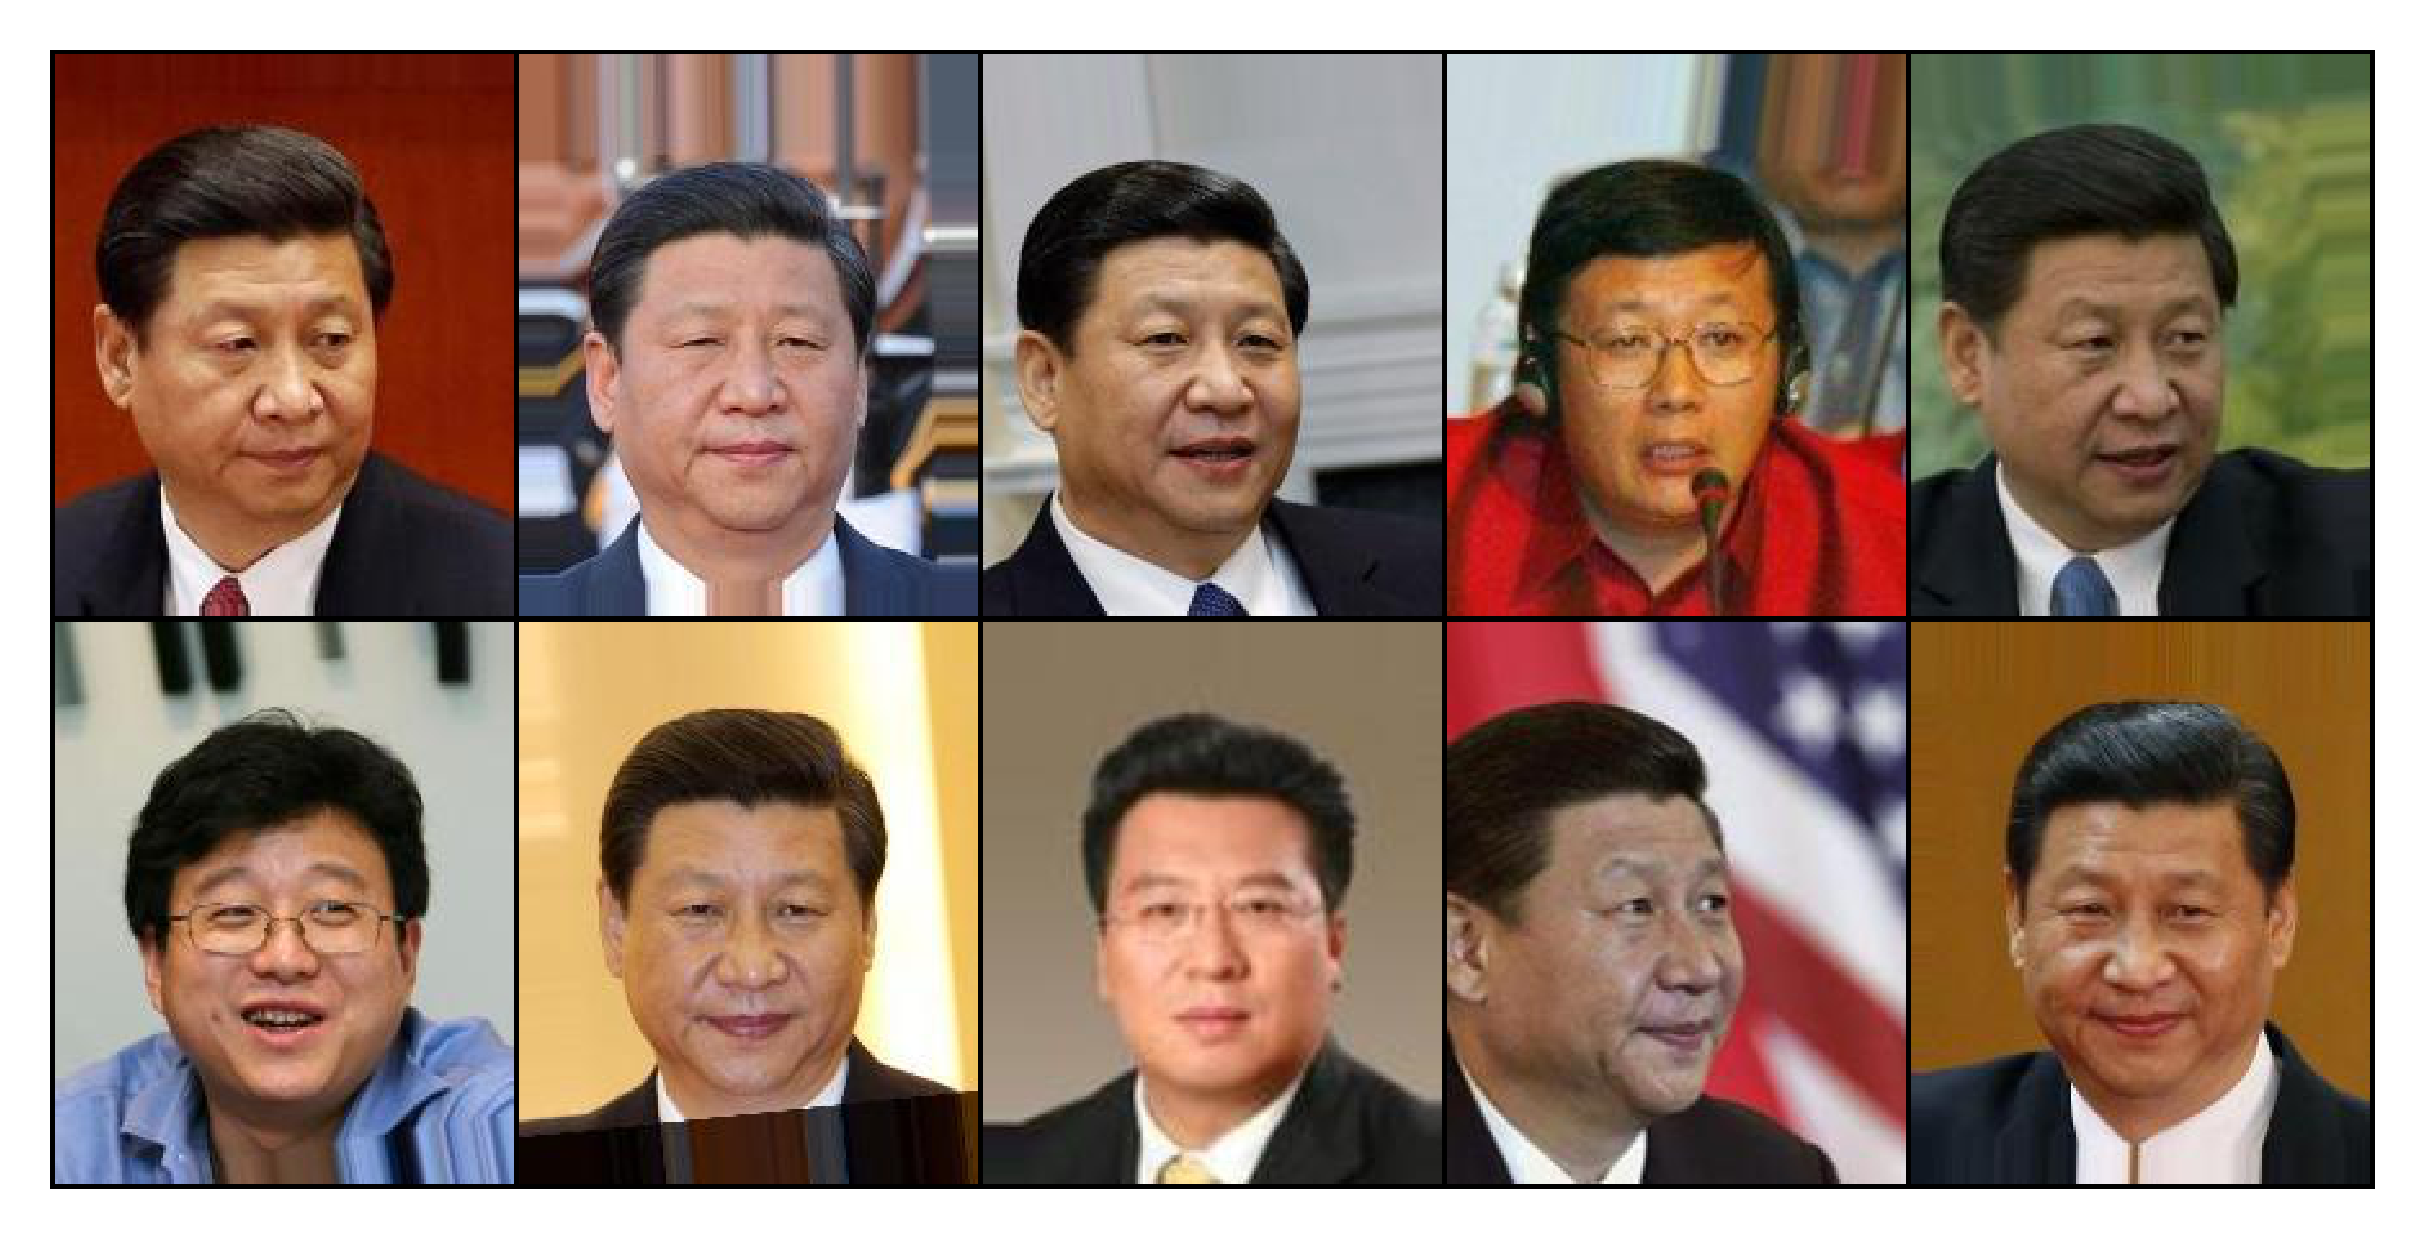

In [9]:
# find the k most similar faces
k = 10
k_closest_indices = np.argsort(distances)[:k]
k_closest_filenames = np.array(filenames)[k_closest_indices]
k_closest_images = []
for f in k_closest_filenames:
    k_closest_images.append(transforms.ToTensor()(Image.open(f'img_align_celeba/{f}')))
k_closest_images = torch.stack(k_closest_images)
k_closest_images = np.transpose(make_grid(k_closest_images, nrow=5), (1, 2, 0))
plt.figure(dpi=500)
plt.axis('off')
plt.imshow(k_closest_images)
plt.savefig('./results/k_closest_faces.png')